## Google Colab Setup <a target="_blank" style="display: inline" href="https://colab.research.google.com/github/vinayak19th/QML-Tutorials/blob/master/ImplicitModel.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
Code Block below sets up Google Colab to run our code.

In [1]:
try:
    import google.colab
    print("Setting Up Colab notebook")
    !pip install tensorflow==2.16.1 pennylane matplotlib scikit-learn -q
    print("Installed Packages")
    import os 
    if(not os.path.exists("../QML-Tutorials")):
        !git clone https://github.com/vinayak19th/QML-Tutorials.git 
        %cd QML-Tutorials
    print("Fetched Data")
    %load_ext tensorboard
    IS_COLAB : bool = True
except ImportError:
    print("Not running in Google Colab")
    IS_COLAB : bool = False

Not running in Google Colab


In [2]:
import pennylane as qml
import matplotlib.pyplot as plt
import pennylane.numpy as np
import io
import tensorflow as tf
%matplotlib inline

2024-09-25 20:12:57.814100: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 20:12:57.842059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Defining the Implicit Model
Setting up the [pennylane device](https://docs.pennylane.ai/en/stable/code/api/pennylane.device.html). The device defines the number of qubit in the ciruit and the backend (i.e type of simulator, real device, etc).

In [3]:
n_qubits =2 
dev = qml.device("lightning.qubit",wires=n_qubits)

We create our variational model. Every [*'Rot'*](https://docs.pennylane.ai/en/stable/code/api/pennylane.Rot.html) operation is the [$R_X$](https://docs.pennylane.ai/en/stable/code/api/pennylane.RX.html),[$R_Y$](https://docs.pennylane.ai/en/stable/code/api/pennylane.RY.html),[$R_Z$](https://docs.pennylane.ai/en/stable/code/api/pennylane.RZ.html) applied in series. Our weight vector will hence have the shape [n_layers,n_qubits,3], which in this case is [3,2,3] (3 layers and 2 qubits).

However, for the implicit model we have to modify our inputs and also apply the inverse of our circuit as well. This is done via the [qml.adjoint](https://docs.pennylane.ai/en/stable/code/api/pennylane.adjoint.html) function. This procedure is known as the [inversion test](https://library.fiveable.me/key-terms/quantum-machine-learning/inversion-test). We can use the result of this test to measure the state fidelity . <u>Our state can be thought of as a <i>'Projector'</i></u>, which we would apply to the computational state $\ket{0..0}\bra{0..0}$ in order to get the fidelity. The mathematical proof can be seen below for our encoding function '*$S(x)$*'

$$
\begin{split}
    &\bra{0..0}S(x_1)S(x_2)^\dagger \mathcal{M} S(x_2)^\dagger S(x_1)\ket{0..0} \\
    &= \bra{0..0}S(x_1)S(x_2)^\dagger \ket{0..0} \bra{0..0} S(x_2)^\dagger S(x_1)\ket{0..0} \\
    &= |\bra{0..0}S(x_1)S(x_2)^\dagger \ket{0..0}|^2 \\
    &= |\braket{\psi(x_1)|\psi(x_2)}|^2 = \mathcal{K}(x_1,x_2)
\end{split}
$$

We could for a **lower gate cost** and **higher qubit cost** use the SWAP Test method which would require us to use 2 sets of qubits to prepare the states $\ket{\phi(x_1)}$ and $\ket{\phi(x_2)}$

In [4]:
projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

As we can see below, the projector is nothing but the density matrix for our $\ket{0..0}$ state (i.e. $\ket{0..0}\bra{0..0}$)

In [5]:
print(projector)

[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [6]:
def encoding(inp, weights):
    qml.RY(inp[0], wires=0)
    qml.RY(inp[1], wires=1)
    for layer in range(weights.shape[0]):
        for wire in range(2):
            qml.Rot(*weights[layer][wire], wires=wire)
        if(layer%2==0):
            qml.CNOT([0, 1])
        else:
            qml.CNOT([1, 0])
    
@qml.qnode(dev)
def Q_Kernel(x0,x1, weights):
    encoding(x0,weights)
    qml.adjoint(encoding)(x1,weights)
    # return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))
    return qml.probs(wires=range(n_qubits))

def implicit_model(x0,x1, weights):
    return Q_Kernel(x0,x1, weights)[0]

In [7]:
x0 = np.array([0.5, 0.1])
x1 = np.array([0.7*np.pi, 0.1*np.pi])
# inputs = tf.constant([[0.5, 0.1],[0.5,0.1]])
weights = qml.numpy.random.uniform(size=(3,2,3),low=0,high=2 * np.pi,requires_grad=True)

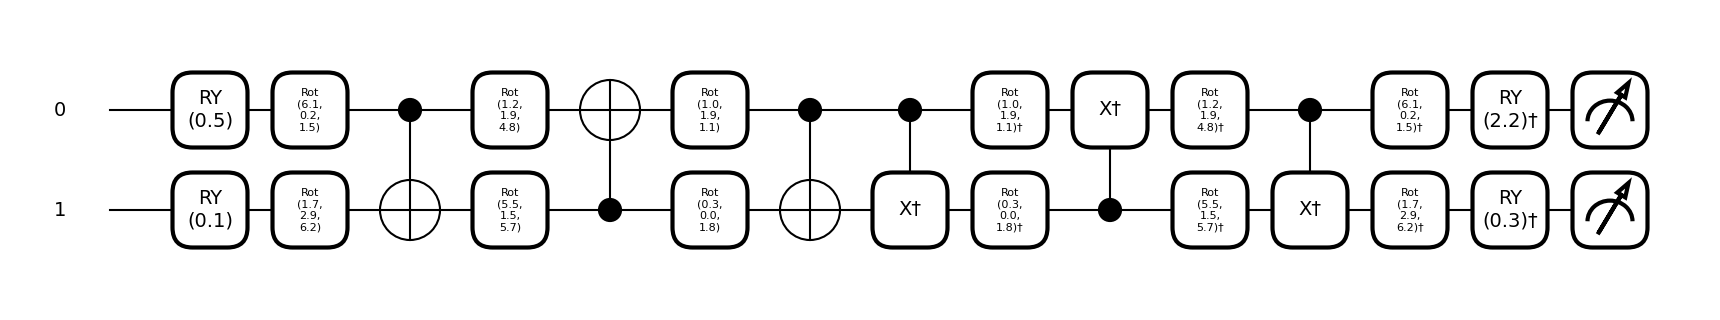

In [8]:
fig = qml.draw_mpl(Q_Kernel,level='gradient',decimals=1)(x0,x1,weights)
plt.savefig("./ImplicitModel.png")
plt.show()

In [9]:
implicit_model(x0,x1,weights)

0.43103635107088684

**Note**: Our implicit model is equivalent to a *Quantum Kernel* at this point and we can train with any kernel classifier such as a Support Vector Machine (SVM).

## Loading our dataset

In [10]:
x = np.load("./Saved_vars/3Layer/x_3.npy")
y = np.load("./Saved_vars/3Layer/y_3.npy")
true_labels = np.load("./Saved_vars/3Layer/labels_3.npy")

We need to stack our 'x' and 'y' for our variational model to accept the inputs

In [11]:
data = np.stack([x,y],axis=1)
print(data.shape)

(1024, 2)


**Data Pre-Processing**: We need to change our label range from $\{-1,1\} \rightarrow \{0,1\}$ we can do this via the simple transform function:
$$
f(x) = \frac{x+1}{2} \tag{1}
$$
As this function is monotonic, the <u>transformation will not affect our optimization objective</u>

In [12]:
def expectation_range_transform(x):
    return np.divide(np.add(x,1),2)

In [80]:
labels = expectation_range_transform(true_labels)

Defining our initial kernel function. We wrap out model in a [lambda function](https://www.w3schools.com/python/python_lambda.asp) to make training easier by fixing our weights. We can also do this with a <u>partial function</u>.

In [14]:
init_kernel = lambda x1, x2: implicit_model(x1, x2, weights)

Computing the [*Gram Matrix*](https://en.wikipedia.org/wiki/Gram_matrix) ($G$) of our kernel w.r.t our data set. The gram matrix can be defined as:
$$
    G(V) = \braket{v_i,v_j} \quad \forall v_i,v_j \in V
$$

Pennylane has a helper function [qml.kernels.square_kernel_matrix](https://docs.pennylane.ai/en/stable/code/api/pennylane.kernels.square_kernel_matrix.html) to help compute this matrix

### Plotting our data
To see the decision boundry, we plot our dataset

In [15]:
def plot_preds(labels,x,y,title='Target dataset',get_img:bool=False):
    for label in set(labels):
        x_subset = [x_i for i, x_i in enumerate(x) if labels[i] == label]
        y_subset = [y_i for i, y_i in enumerate(y) if labels[i] == label]
        marker = 'v' if label == 0.0 else 'x'  # Example markers: 'o' for circles, 'x' for crosses
        plt.scatter(x_subset, y_subset, label=label, marker=marker)
    
    # Add labels, title, and legend
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(title)
    if(get_img):
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img = tf.image.decode_png(buf.getvalue(), channels=3)
        buf.close()
        plt.show()
        return tf.expand_dims(img,0)
    plt.show()

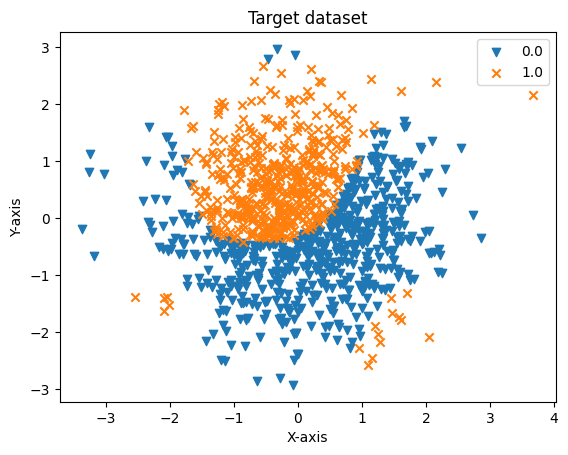

In [16]:
target_img = plot_preds(labels.numpy(),x,y,get_img=True)

## Training the model
To train the model we need to randomly sample points from our dataset. We need to ensure that we have an even number of points from both classes to train the model properly

In [105]:
def sample_random_classes(data,labels,num_samples=50):
    samples_0 = np.array([x_i for i, x_i in enumerate(data) if labels[i] == -1])
    samples_1 = np.array([x_i for i, x_i in enumerate(data) if labels[i] == 1])
    
    num_samples_0 = num_samples//2
    num_samples_1 = num_samples - num_samples_0
    
    idx = np.random.choice(np.arange(0,samples_0.shape[0]),size=num_samples_0)
    samples_0 = samples_0[idx]
    
    llabels = np.ones(samples_0.shape[0])*-1
    
    idx = np.random.choice(np.arange(0,samples_1.shape[0]),size=num_samples_1)
    samples_1 = samples_1[idx]
    
    llabels = np.concatenate([llabels, np.ones(samples_1.shape[0])])
    points = np.concatenate([samples_0,samples_1])
    
    return points, llabels

In [111]:
selected_points, selected_labels = sample_random_classes(data,true_labels,900)

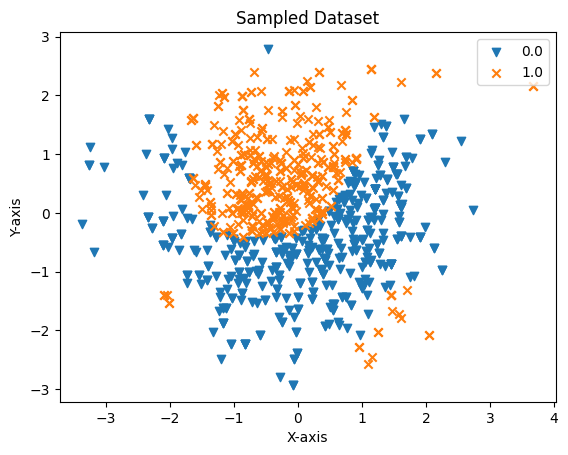

In [112]:
plot_preds(expectation_range_transform(selected_labels),selected_points[:,0],selected_points[:,1],title="Sampled Dataset")

In [113]:
K_init = qml.kernels.square_kernel_matrix(selected_points[:5], init_kernel, assume_normalized_kernel=True)

**Note: As this is an extremely expensive operation (and not accelerated), we will sample a subset of our data** 

In [114]:
K_init

array([[1.00000000e+00, 2.71495413e-01, 1.36926671e-03, 1.84843967e-02,
        1.50291808e-02],
       [2.71495413e-01, 1.00000000e+00, 6.96791065e-03, 9.75631162e-02,
        8.51881659e-04],
       [1.36926671e-03, 6.96791065e-03, 1.00000000e+00, 5.12088550e-01,
        9.66516050e-01],
       [1.84843967e-02, 9.75631162e-02, 5.12088550e-01, 1.00000000e+00,
        6.79389773e-01],
       [1.50291808e-02, 8.51881659e-04, 9.66516050e-01, 6.79389773e-01,
        1.00000000e+00]])

Defining the Kernel Classifier

In [115]:
from sklearn.svm import SVC

In [116]:
svc = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel),verbose=True)

**Utility Function -> Plot Model** helps us plot the current predictions of the model

**NOTE:** The kernel.fit will not modify the weights in our quantum circuit and will only adjust the weights of the hyperplane to draw decision boundry.

In [120]:
svc.fit(data[:10],labels[:10])

[LibSVM]*
optimization finished, #iter = 7
obj = -5.336946, rho = 0.658200
nSV = 8, nBSV = 5
Total nSV = 8


SVC(kernel=<function <lambda> at 0x7f8fd78c1bc0>, verbose=True)

In [122]:
def get_model_preds(data,model):
    labels = np.sign(model.predict(data))
    return expectation_range_transform(labels)

In [123]:
y_preds = get_model_preds(data[:800],svc)

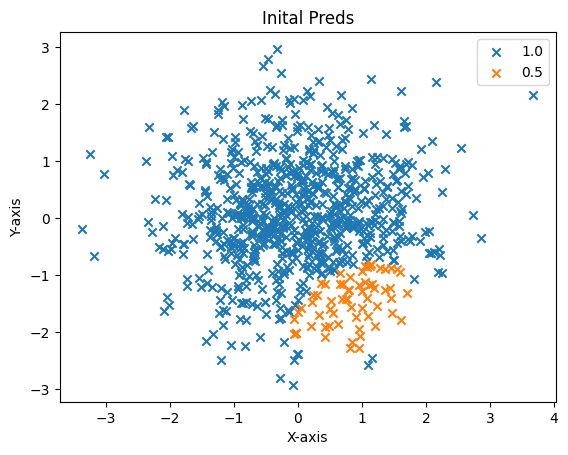

In [124]:
plot_preds(y_preds,data[:800,0],data[:800,1],title="Inital Preds")

### Training loop over data
To visuallize the effect of data on our classifier, we randomly select small samples of data and train iteratively over them. 

*Notes:*
1. We cannot train on the entire dataset due to the time it takes and how computationally expensive it is

In [127]:
batch_size = 10
steps = 10
print("step_size:",steps)

step_size: 10


Reshape the dataset and labels to be in batches

In [128]:
run = 2
logdir = f"logs/train_data/ImplicitModel/run_{run}"
file_writer = tf.summary.create_file_writer(logdir)
description = f"Implicit Model run {run} -> layers {weights.shape[0]} | {weights.shape[0] *3}  Trainable Parameters | {steps} steps"
print(description)

Implicit Model run 2 -> layers 3 | 9  Trainable Parameters | 10 steps


#### Kernel Alignment
We utilize a specialized function known as [Kernel Alignment](https://link.springer.com/article/10.1007/s10462-012-9369-4)($KA$) to train our model. 
$$
    KA(K_1,K_2) = \frac{Tr(K_1K_2)}{\sqrt{Tr(K_1^2)Tr(K_2^2)}}
$$
The $KA$ here forms a similarity metric between 2 kernels $K_1$,$K_2$. 

(*We initialize with 10 sample points to demonstrate the outputs*)

In [131]:
selected_points, selected_labels = sample_random_classes(data,true_labels,10)

In [132]:
print(list(selected_labels))

[tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(1., requires_grad=True), tensor(1., requires_grad=True), tensor(1., requires_grad=True), tensor(1., requires_grad=True), tensor(1., requires_grad=True)]


In order to train our kernel using the $KA$ metric. We need to define an **ideal kernel** based on the true labels. We use a **'Labelling Function'** ($LF$) as defined below, for our ideal kernel.
$$
    LF(y_1,y_2) =  \begin{cases} 
                      -1 & \text{if } y_1 \neq y_2 \\
                      1 & \text{if } y_1 = y_2
                   \end{cases}
$$
As our actual labels are in set $\{-1,1\}$, our $LF(y_1,y_2) = y_1 \times y_2 $ 


In [133]:
label_fn = lambda y1,y2: y1*y2

The kernel matrix for our labelling function = $yy^T$. The pennylane [qml.kernels.target_alignment](https://docs.pennylane.ai/en/stable/code/api/pennylane.kernels.target_alignment.html) computes both these quantities, assuming that label $\in \{-1,1\}$. Based on this condition we can simplify the $KA$ function to be univariate and set the kernel to compare against as the labelling kernel.
$$
    KA(K) = \frac{y^TKy}{\sqrt{Tr(K^2)}N} \quad \text{where }N=\text{\# of elements in }y
$$

In [134]:
kta_init = qml.kernels.target_alignment(selected_points, selected_labels, init_kernel, assume_normalized_kernel=True)

In [135]:
print(kta_init)

0.11189431462679279


**Training**: The build-in pennylane function does not support automatic differentiation and we need to code out the differentiable function ourselves.

In [136]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

Defining training parameters:
* We define the optimizer to learn our model weights
* number of epochs to train
* sample_ratio that defines the number of random points we select for training

In [181]:
opt = qml.GradientDescentOptimizer(0.1)
epochs = 15
sample_ratio : float = 0.02
svm_samples = 5

In [182]:
print(f"{np.floor(1024*sample_ratio)} points will be used per training iteration")

20.0 points will be used per training iteration


We define a helper function to predict labels from our model

In [183]:
def get_classifier(weights,sample_data,sample_labels):
    trained_kernel = lambda x1, x2: implicit_model(x1, x2, weights)
    trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)
    return SVC(kernel=trained_kernel_matrix).fit(sample_data,sample_labels)

TF File writer for tensorboard

In [184]:
run = 5
logdir = f"logs/train_data/ImplicitModel/run_{run}"
file_writer = tf.summary.create_file_writer(logdir)
description = f"Data Reuploader run {run} -> layers {weights.shape[0]} | {weights.shape[0] *3}  Trainable Parameters | {epochs} Epochs"
print(description)

Data Reuploader run 5 -> layers 3 | 9  Trainable Parameters | 15 Epochs


In [185]:
weights = qml.numpy.random.uniform(size=(3,2,3),low=0,high=2 * np.pi,requires_grad=True)

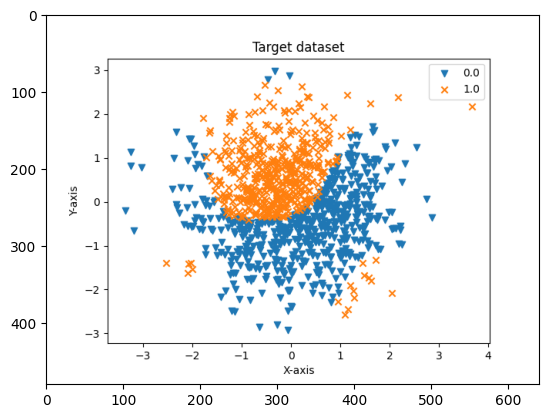

In [186]:
plt.imshow(target_img[0])
plt.show()

with file_writer.as_default():
  tf.summary.image("Target Data", target_img, step=0)

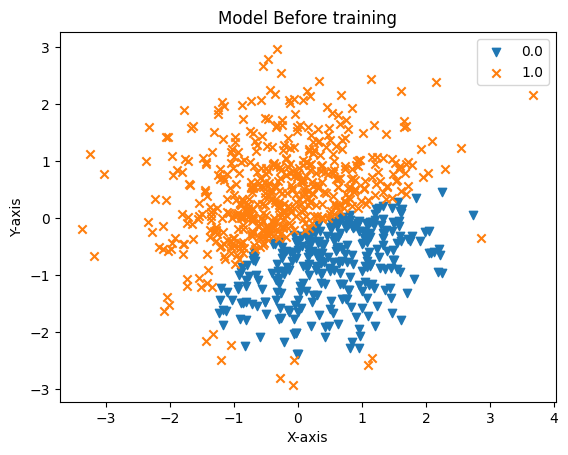

In [187]:
selected_points, selected_labels = sample_random_classes(data,true_labels,svm_samples)
classifier = get_classifier(weights,selected_points,selected_labels)
y_preds = get_model_preds(data[:800],classifier)
img = plot_preds(y_preds,data[:800,0],data[:800,1],title=f"Model Before training",get_img=True)
with file_writer.as_default():
    tf.summary.image("Training Progress", img, step=-1)

Training the model involves randomly select a subset of our data and optimize our kernel weights.

In [189]:
best_weights = weights
best_alignment = 0

Step 2 - Alignment = 0.224


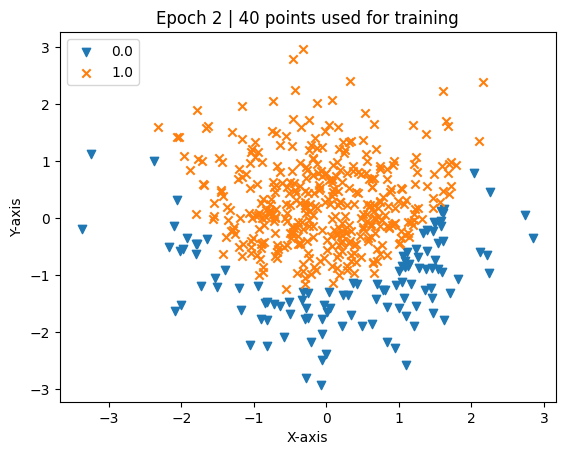

Step 4 - Alignment = 0.281


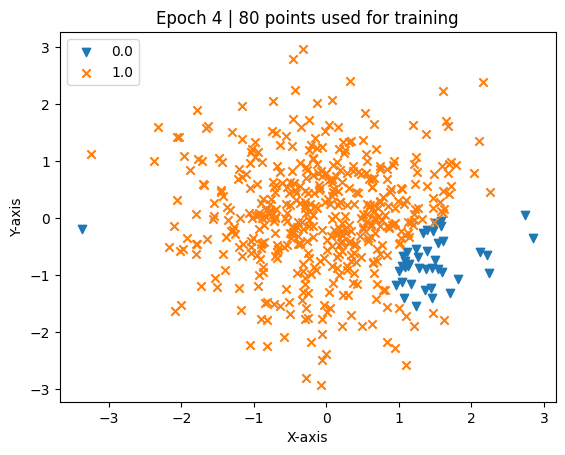

Step 6 - Alignment = 0.167


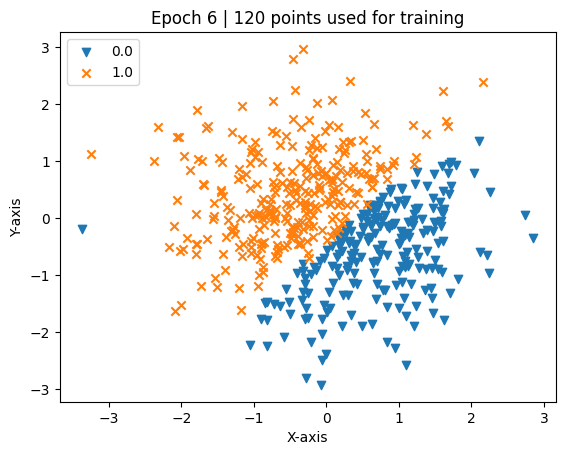

Step 8 - Alignment = 0.163


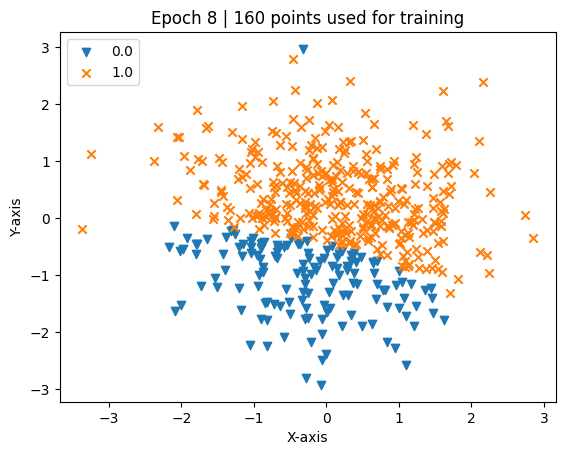

Step 10 - Alignment = 0.224


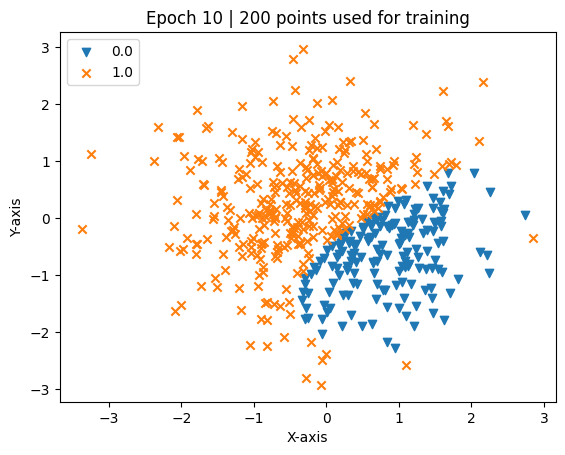

Step 12 - Alignment = 0.172


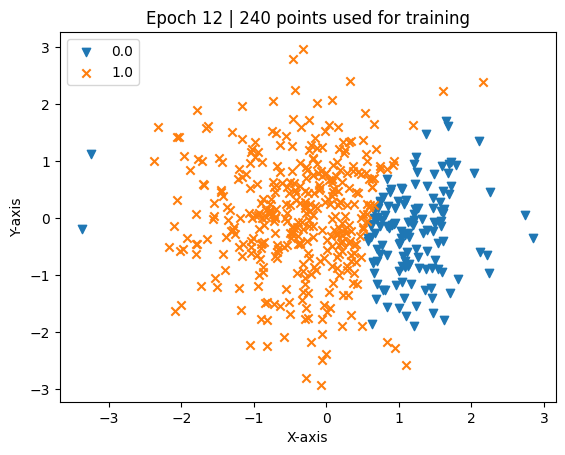

Step 14 - Alignment = 0.250


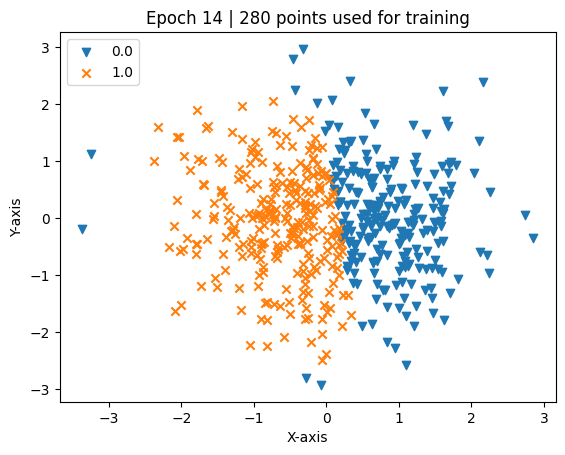

In [190]:
for i in range(epochs):
    print(f"Current Epoch {i}",end="\r")
    # Choose subset of datapoints to compute the KTA on.
    selected_points, selected_labels = sample_random_classes(data,true_labels,int(np.floor(1024*sample_ratio)))
    selected_points = qml.numpy.array(selected_points, requires_grad=True)
    selected_labels = qml.numpy.array(selected_labels, requires_grad=True)
    
    # Define the cost function for optimization
    cost = lambda weights: -target_alignment(
        selected_points,
        selected_labels,
        lambda x1, x2: implicit_model(x1, x2, weights),
        assume_normalized_kernel=True,
    )
    # Optimization step
    weights = opt.step(cost, weights)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 2 == 0:
        current_alignment = target_alignment(
            selected_points,
            selected_labels,
            lambda x1, x2: implicit_model(x1, x2, weights),
            assume_normalized_kernel=True,
        )
        if(current_alignment>=best_alignment):
            best_alignment = current_alignment
            best_weights = weights
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")
        selected_points, selected_labels = sample_random_classes(data,true_labels,svm_samples)
        classifier = get_classifier(weights,selected_points,selected_labels)
        y_preds = get_model_preds(data[:500],classifier)
        plots = plot_preds(y_preds,data[:500,0],data[:500,1],title=f"Epoch {i+1} | {int(np.floor(1024*sample_ratio))*(i+1)} points used for training",get_img=True)
        with file_writer.as_default():
            tf.summary.image("Training Progress", plots, step=i)

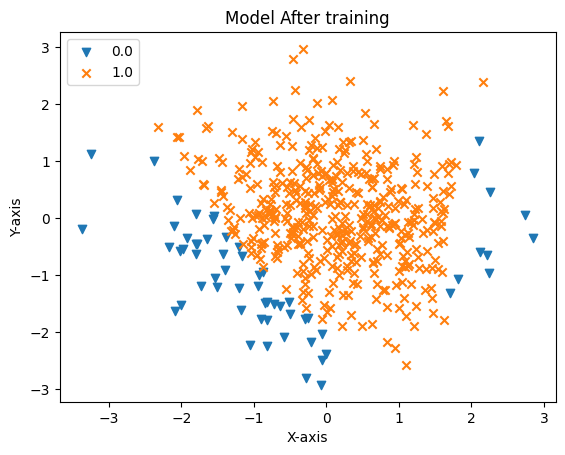

In [195]:
selected_points, selected_labels = sample_random_classes(data,true_labels,2)
classifier = get_classifier(best_weights,selected_points, selected_labels)
y_preds = get_model_preds(data[:500],classifier)
plots = plot_preds(y_preds,data[:500,0],data[:500,1],title=f"Model After training",get_img=True)
with file_writer.as_default():
  tf.summary.image("Training Progress", plots, step=i+1)

In [192]:
np.save("./Saved_vars/weights_implicit.npy",best_weights)

In [178]:
current_alignment = target_alignment(
            selected_points,
            selected_labels,
            lambda x1, x2: implicit_model(x1, x2, weights),
            assume_normalized_kernel=True,
        )

In [193]:
current_alignment

tensor(0.24976189, requires_grad=True)

In [153]:
file_writer.close()

In [ ]:
if(IS_COLAB):
    %tensorboard --logdir logs